IMPORT LIBRERIE

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
import os
import shutil
import random
from random import randint
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from skimage.io import imread
import pathlib
import glob2 
from glob2 import glob
import cv2
import sys
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

FILEPATH

In [2]:
#definizione filepath

data_dir="..\\Data\\Original"
data_dir = pathlib.Path(data_dir)

fin_dir="..\\Data\\Prepared"
fin_dir = pathlib.Path(fin_dir)

path_all = list(glob2.glob("..\\Data\\Original\\*\\*.bmp"))
path_Negative = pathlib.Path('..\\Data\\Original\\NOK\\*.bmp')
path_Negative = pathlib.Path('..\\Data\\Original\\OK\\*.bmp')


DATA EXPLORATION

In [3]:
#conteggio delle immagini presenti all'interno di Original
image_count = len(list(data_dir.glob('*\\*.bmp')))
print(image_count)

123


In [4]:
#conteggio delle immagini presenti all'interno di Original\\OK
image_count = len(list(data_dir.glob('OK\\*.bmp')))
print(image_count)

104


In [5]:
#conteggio delle immagini presenti all'interno di Original\\NOK
image_count = len(list(data_dir.glob('NOK\\*.bmp')))
print(image_count)

19


Text(0.5, 1.0, 'NOK and OK')

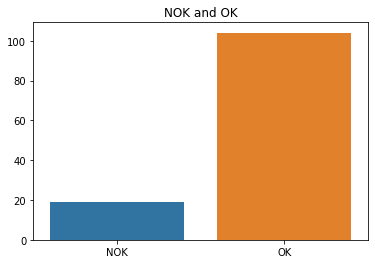

In [6]:
#verifichiamo la distribuzione di OK e NOK
sns.barplot(x=['NOK','OK'], y=[len(list(data_dir.glob('NOK\\*.bmp'))), len(list(data_dir.glob('OK\\*.bmp')))])
plt.title('NOK and OK')


In [7]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,..\Data\Original\OK\OK (71).bmp,OK
1,..\Data\Original\OK\OK (65).bmp,OK
2,..\Data\Original\OK\OK (10).bmp,OK
3,..\Data\Original\OK\OK (18).bmp,OK
4,..\Data\Original\OK\OK (87).bmp,OK


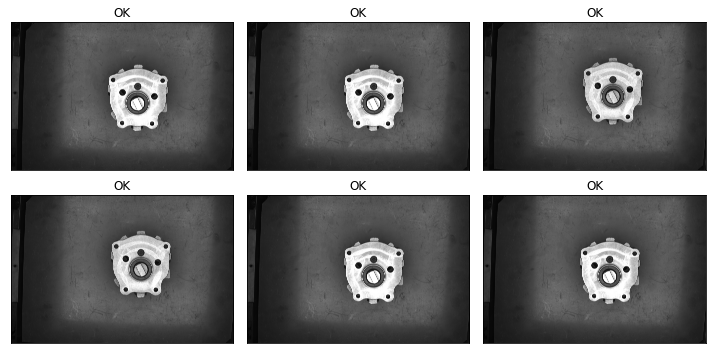

In [8]:
#plot immagini a scopo esplorativo
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [9]:
#verifica delle dimenzioni e del canale colore delle immagini presenti in Data\\Original
size_images = dict()


for dirpath, _, filenames in os.walk(data_dir):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            mode = img.mode
            size_images[path_image] = {'width': width, 'heigth': heigth,'mode':mode}
print(size_images)
#tutte le immagini presentano lo stesso valore per l'altezza e la larghezza (5472x3648) e rgb come canale colore

{'NOK (1).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (10).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (11).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (12).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (13).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (14).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (15).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (16).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (17).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (18).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (19).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (2).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (3).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (4).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (5).bmp': {'width': 5472, 'heigth': 3648, 'mode': 'RGB'}, 'NOK (6).bmp': {'width': 5472, 'heigth': 364

PREPROCESSING

1)CROP

In [10]:
#creazione cartella Prepared
directory = 'Prepared'
parent_dir = '..\\Data'   
path = os.path.join(parent_dir, directory)

os.mkdir(path) 
print("Directory '% s' created" % directory)

#creazione cartella Prepared\\ok
directory = 'ok'
parent_dir = '..\\Data\\Prepared\\'   
path = os.path.join(parent_dir, directory)

os.mkdir(path) 
print("Directory '% s' created" % directory)

#creazione cartella Prepared\\nok
directory = 'nok'
parent_dir = '..\\Data\\Prepared\\'   
path = os.path.join(parent_dir, directory)

os.mkdir(path) 
print("Directory '% s' created" % directory)

Directory 'Prepared' created
Directory 'ok' created
Directory 'nok' created


In [11]:
#crop immagini ok e nok presenti nella cartella Original e trasferimento immagini croppate in Prepared

#Prepared\\ok
path= "..\\Data\\Original\\OK"
dest_path="..\\Data\\Prepared\\ok"

for f in os.listdir(path):
    image = cv2.imread(os.path.join(path, f))
    imgcropped = image [750:2868, 2178:4200]
    cv2.imwrite(os.path.join(dest_path, f), imgcropped)

#Prepared\\nok
path= "..\\Data\\Original\\NOK"
dest_path="..\\Data\\Prepared\\nok"


for f in os.listdir(path):
    image = cv2.imread(os.path.join(path, f))
    imgcropped = image [750:2868, 2178:4200]
    cv2.imwrite(os.path.join(dest_path, f), imgcropped)

2)BACKGROUND THRESHOLD

In [12]:
#applicazione della threshold alle immagini presenti in Data\\Prepared\\ok al fine di ridurre il rumore causato dallo sfondo

in_dir = "..\\Data\\Prepared\\ok"
out_dir = "..\\Data\\Prepared\\ok"

infiles = in_dir + '/*.bmp'
img_names = glob(infiles)
print(img_names)

for fn in img_names:
    print('processing %s...' % fn)

    im_gray = cv2.imread(fn, 0)

    im_bw = cv2.threshold(im_gray, 127, 255, cv2.THRESH_TOZERO)[1]

    im_bw = cv2.cvtColor(im_bw,cv2.COLOR_GRAY2RGB)

    name = os.path.basename(fn)
    outfile = out_dir + '/' + name
    cv2.imwrite(outfile, im_bw)

['..\\Data\\Prepared\\ok\\OK (1).bmp', '..\\Data\\Prepared\\ok\\OK (10).bmp', '..\\Data\\Prepared\\ok\\OK (100).bmp', '..\\Data\\Prepared\\ok\\OK (101).bmp', '..\\Data\\Prepared\\ok\\OK (102).bmp', '..\\Data\\Prepared\\ok\\OK (103).bmp', '..\\Data\\Prepared\\ok\\OK (104).bmp', '..\\Data\\Prepared\\ok\\OK (11).bmp', '..\\Data\\Prepared\\ok\\OK (12).bmp', '..\\Data\\Prepared\\ok\\OK (13).bmp', '..\\Data\\Prepared\\ok\\OK (14).bmp', '..\\Data\\Prepared\\ok\\OK (15).bmp', '..\\Data\\Prepared\\ok\\OK (16).bmp', '..\\Data\\Prepared\\ok\\OK (17).bmp', '..\\Data\\Prepared\\ok\\OK (18).bmp', '..\\Data\\Prepared\\ok\\OK (19).bmp', '..\\Data\\Prepared\\ok\\OK (2).bmp', '..\\Data\\Prepared\\ok\\OK (20).bmp', '..\\Data\\Prepared\\ok\\OK (21).bmp', '..\\Data\\Prepared\\ok\\OK (22).bmp', '..\\Data\\Prepared\\ok\\OK (23).bmp', '..\\Data\\Prepared\\ok\\OK (24).bmp', '..\\Data\\Prepared\\ok\\OK (25).bmp', '..\\Data\\Prepared\\ok\\OK (26).bmp', '..\\Data\\Prepared\\ok\\OK (27).bmp', '..\\Data\\Prepared\\

In [13]:
#applicazione della threshold alle immagini presenti in Data\\Prepared\\nok al fine di ridurre il rumore causato dallo sfondo

in_dir = "..\\Data\\Prepared\\nok"
out_dir = "..\\Data\\Prepared\\nok"

infiles = in_dir + '/*.bmp'
img_names = glob(infiles)
print(img_names)

for fn in img_names:
    print('processing %s...' % fn)

    im_gray = cv2.imread(fn, 0)

    im_bw = cv2.threshold(im_gray, 127, 255, cv2.THRESH_TOZERO)[1]

    im_bw = cv2.cvtColor(im_bw,cv2.COLOR_GRAY2RGB)

    name = os.path.basename(fn)
    outfile = out_dir + '/' + name
    cv2.imwrite(outfile, im_bw)

['..\\Data\\Prepared\\nok\\NOK (1).bmp', '..\\Data\\Prepared\\nok\\NOK (10).bmp', '..\\Data\\Prepared\\nok\\NOK (11).bmp', '..\\Data\\Prepared\\nok\\NOK (12).bmp', '..\\Data\\Prepared\\nok\\NOK (13).bmp', '..\\Data\\Prepared\\nok\\NOK (14).bmp', '..\\Data\\Prepared\\nok\\NOK (15).bmp', '..\\Data\\Prepared\\nok\\NOK (16).bmp', '..\\Data\\Prepared\\nok\\NOK (17).bmp', '..\\Data\\Prepared\\nok\\NOK (18).bmp', '..\\Data\\Prepared\\nok\\NOK (19).bmp', '..\\Data\\Prepared\\nok\\NOK (2).bmp', '..\\Data\\Prepared\\nok\\NOK (3).bmp', '..\\Data\\Prepared\\nok\\NOK (4).bmp', '..\\Data\\Prepared\\nok\\NOK (5).bmp', '..\\Data\\Prepared\\nok\\NOK (6).bmp', '..\\Data\\Prepared\\nok\\NOK (7).bmp', '..\\Data\\Prepared\\nok\\NOK (8).bmp', '..\\Data\\Prepared\\nok\\NOK (9).bmp']
processing ..\Data\Prepared\nok\NOK (1).bmp...
processing ..\Data\Prepared\nok\NOK (10).bmp...
processing ..\Data\Prepared\nok\NOK (11).bmp...
processing ..\Data\Prepared\nok\NOK (12).bmp...
processing ..\Data\Prepared\nok\NOK (1

3)DATA AUGMENTATION-ROTAZIONI

In [14]:
#applichiamo delle trasformazioni alle immagini presenti in Data\\Prepared\\nok al fine di rendere il dataset bilanciato

def main():
    img_dir = "..\\Data\\Prepared\\nok"

    bmp_ext = ".bmp"
    angles = [5,7,10,12,15,18,20, 75,80,82,85,88,90, 175,180, 265,270,270, 275,277,280,285,290,295,310,340,350]
    for file_name in glob2.iglob(os.path.join(img_dir, "*" + bmp_ext)):
        image = Image.open(file_name)
        for angle in angles:
            rot_suffix = "_r{:03d}{:s}".format(angle, bmp_ext)
            file_name_rot = file_name.replace(bmp_ext, rot_suffix)
            image_rot = image.rotate(angle)
            image_rot.save(file_name_rot)
            print("Rotated: {:s} by {:3d} degrees to {:s}".format(file_name, angle, file_name_rot))


if __name__ == "__main__":
    print("Python {:s} on {:s}\n".format(sys.version, sys.platform))
    main()
    print("\nDone.")

Python 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)] on win32

Rotated: ..\Data\Prepared\nok\NOK (1).bmp by   5 degrees to ..\Data\Prepared\nok\NOK (1)_r005.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by   7 degrees to ..\Data\Prepared\nok\NOK (1)_r007.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  10 degrees to ..\Data\Prepared\nok\NOK (1)_r010.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  12 degrees to ..\Data\Prepared\nok\NOK (1)_r012.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  15 degrees to ..\Data\Prepared\nok\NOK (1)_r015.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  18 degrees to ..\Data\Prepared\nok\NOK (1)_r018.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  20 degrees to ..\Data\Prepared\nok\NOK (1)_r020.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  75 degrees to ..\Data\Prepared\nok\NOK (1)_r075.bmp
Rotated: ..\Data\Prepared\nok\NOK (1).bmp by  80 degrees to ..\Data\Prepared\nok\NOK (1)_r080.bmp
Rotated: ..\Data\Prepared\nok\NOK 

In [15]:
#applichiamo delle trasformazioni alle immagini presenti in Data\\Prepared\\ok al fine di rendere il dataset bilanciato

def main():
    img_dir = "..\\Data\\Prepared\\ok"

    bmp_ext = ".bmp"
    angles = [5,20,180,280]
    for file_name in glob2.iglob(os.path.join(img_dir, "*" + bmp_ext)):
        image = Image.open(file_name)
        for angle in angles:
            rot_suffix = "_r{:03d}{:s}".format(angle, bmp_ext)
            file_name_rot = file_name.replace(bmp_ext, rot_suffix)
            image_rot = image.rotate(angle)
            image_rot.save(file_name_rot)
            print("Rotated: {:s} by {:3d} degrees to {:s}".format(file_name, angle, file_name_rot))


if __name__ == "__main__":
    print("Python {:s} on {:s}\n".format(sys.version, sys.platform))
    main()
    print("\nDone.")

Python 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)] on win32

Rotated: ..\Data\Prepared\ok\OK (1).bmp by   5 degrees to ..\Data\Prepared\ok\OK (1)_r005.bmp
Rotated: ..\Data\Prepared\ok\OK (1).bmp by  20 degrees to ..\Data\Prepared\ok\OK (1)_r020.bmp
Rotated: ..\Data\Prepared\ok\OK (1).bmp by 180 degrees to ..\Data\Prepared\ok\OK (1)_r180.bmp
Rotated: ..\Data\Prepared\ok\OK (1).bmp by 280 degrees to ..\Data\Prepared\ok\OK (1)_r280.bmp
Rotated: ..\Data\Prepared\ok\OK (10).bmp by   5 degrees to ..\Data\Prepared\ok\OK (10)_r005.bmp
Rotated: ..\Data\Prepared\ok\OK (10).bmp by  20 degrees to ..\Data\Prepared\ok\OK (10)_r020.bmp
Rotated: ..\Data\Prepared\ok\OK (10).bmp by 180 degrees to ..\Data\Prepared\ok\OK (10)_r180.bmp
Rotated: ..\Data\Prepared\ok\OK (10).bmp by 280 degrees to ..\Data\Prepared\ok\OK (10)_r280.bmp
Rotated: ..\Data\Prepared\ok\OK (100).bmp by   5 degrees to ..\Data\Prepared\ok\OK (100)_r005.bmp
Rotated: ..\Data\Prepared\ok\OK (100).bmp by  20 degrees t

4)RESIZE

In [16]:
#ridimensionamento delle immagini presenti in Data\\Prepared\\ok
f = "..\\Data\\Prepared\\ok"
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    #img = img.resize((224,224)) #resize eventuale per vgg e resnet
    img = img.resize((299,299))
    img.save(f_img)

In [17]:
#ridimensionamento delle immagini presenti in Data\\Prepared\\nok
f = "..\\Data\\Prepared\\nok"
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    #img = img.resize((224,224)) #resize eventuale per vgg e resnet
    img = img.resize((299,299))
    img.save(f_img)

5)CHECK

Text(0.5, 1.0, 'NOK and OK')

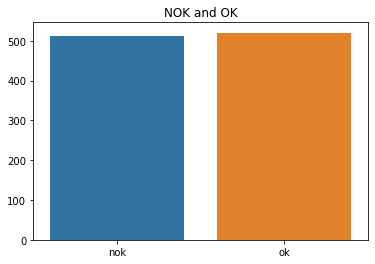

In [18]:
#verifica correzione class imbalance
sns.barplot(x=['nok','ok'], y=[len(list(fin_dir.glob('nok/*.bmp'))), len(list(fin_dir.glob('ok/*.bmp')))])
plt.title('NOK and OK')

In [19]:
#conteggio delle immagini presenti all'interno di Prepared\\ok
image_count = len(list(fin_dir.glob('ok\\*.bmp')))
print(image_count)

520


In [20]:
#conteggio delle immagini presenti all'interno di Prepared\\nok
image_count = len(list(fin_dir.glob('nok\\*.bmp')))
print(image_count)

513


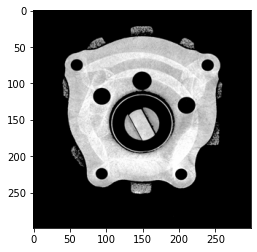

In [21]:
#plot di un immagine presente in Prepared\\ok
image = imread(fname="..\\Data\\Prepared\\ok\\OK (1).bmp")

fig, ax = plt.subplots()
plt.imshow(image)
plt.show()

In [22]:
#verifica rgb e size
image.shape

(299, 299, 3)